### Описание проекта:<br>
Работа в стартапе, который продаёт продукты питания. Нужно разобраться, как ведут себя пользователи вашего мобильного приложения. <br>
Требуется изучить воронку продаж. Узнайте, как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах? На каких именно? <br>
После этого требуется исследовать результаты A/A/B-эксперимента. Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Требуется выяснить, какой шрифт лучше.<br>
<br>
### Описание данных:<br>
Каждая запись в логе — это действие пользователя, или событие. 
* EventName — название события;
* DeviceIDHash — уникальный идентификатор пользователя;
* EventTimestamp — время события;
* ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.


In [185]:
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
import datetime as dt
from plotly import graph_objects as go
import math as mth
from scipy import stats as st

In [186]:
pd.set_option('display.max_columns', 50) 
pd.set_option('display.max_rows', 500)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pd.set_option('display.max_colwidth', False)
# параметры для корректного отображения таблиц и более удобного их анализа

## Знакомство с данными и предобработка

In [188]:
def info(df):
    display(df.head())
    display(df.info())
    display(df.isna().sum())
    display(df.duplicated().sum())

In [189]:
info(df)

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


None

EventName         0
DeviceIDHash      0
EventTimestamp    0
ExpId             0
dtype: int64

413

Стоит привести названия колонок в более читаемый вид. Добавить колонку даты и времени, переведенную в читаемый формат. Также присутствует 413 дубликатов, что для такого массива крайне малая цифра и проще их удалить, чем искать причины их возникновения

In [190]:
df.columns= df.columns.str.lower() #привести названия колонок к нижнему регистру
df = df.rename(columns={'eventname': 'event_name', 'deviceidhash' : 'device_id_hash', 'eventtimestamp' : 'event_timestamp', 'expid' : 'exp_id'}) 
#привести заголовки колонок к snake_case
df = df.drop_duplicates().reset_index(drop=True) # убираем дубликаты 

In [191]:
df['datetime'] = pd.to_datetime(df['event_timestamp'], unit='s') #переводим из unix в человеческий формат
df['date'] = pd.to_datetime(df['datetime']).dt.date # создаем колонку с датой

In [192]:
df['date'] = df['date'].astype(str)
df['date'] = df['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)

In [193]:
df['event_name'].unique() #проверяем на скрытые дубликаты

array(['MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear',
       'OffersScreenAppear', 'Tutorial'], dtype=object)

In [194]:
df.groupby('device_id_hash')['exp_id'].nunique().reset_index().query('exp_id > 1')

,device_id_hash,exp_id


Ни один из пользователей не попал в несколько групп теста сразу

## Изучите и проверьте данные

##### Сколько всего событий в логе?

In [195]:
df_sum_count = df['event_name'].count()
df_sum_count

243713

##### Сколько всего пользователей в логе?

In [196]:
df_sum_uni = df['device_id_hash'].nunique()
df_sum_uni

7551

##### Сколько в среднем событий приходится на пользователя?

In [197]:
df.pivot_table(index='device_id_hash', values='event_name', aggfunc='count').mean()

event_name   32.27559
dtype: float64

##### Данными за какой период мы располагаем? Найдем максимальную и минимальную дату

In [198]:
max(df['datetime'])

Timestamp('2019-08-07 21:15:17')

In [199]:
min(df['datetime'])

Timestamp('2019-07-25 04:43:36')

Text(0, 0.5, 'Кол-во пользователей')

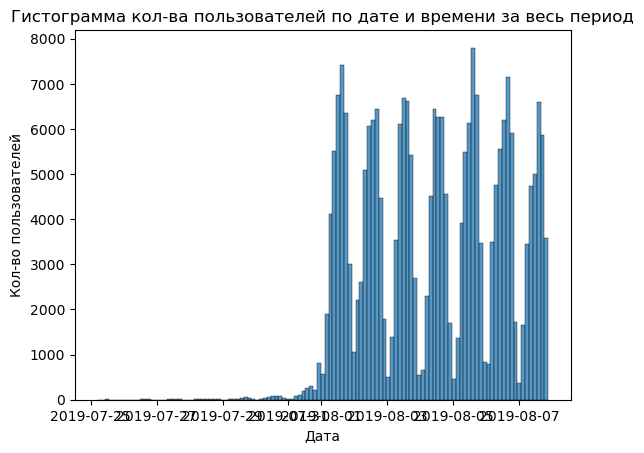

In [200]:
sns.histplot(df['datetime'],kde = False)
plt.title('Гистограмма кол-ва пользователей по дате и времени за весь период')
plt.xlabel('Дата')
plt.ylabel('Кол-во пользователей')

У нас есть данные за последнюю неделю июля и первую неделю августа. Все данные до 1 августа являются нестабильными и их достаточно мало. В связи с этим можно взять в выборку только данные за последние 7 дней выборки

Text(0, 0.5, 'Кол-во пользователей')

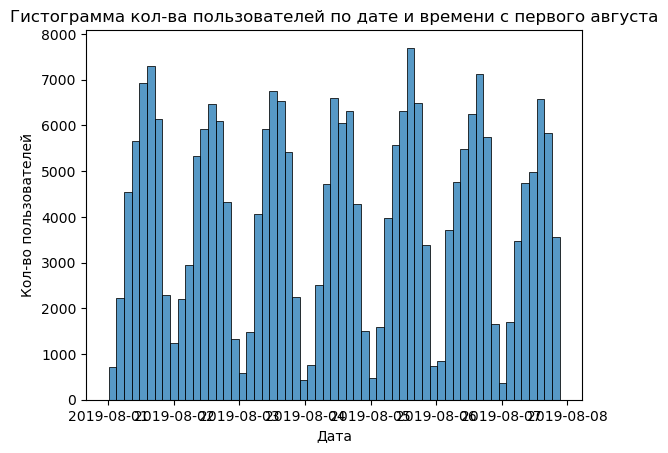

In [201]:
df = df.query('date > "2019-07-31"')
sns.histplot(df['datetime'],kde = False)
plt.title('Гистограмма кол-ва пользователей по дате и времени с первого августа')
plt.xlabel('Дата')
plt.ylabel('Кол-во пользователей')

##### Проверяем много ли событий и пользователей мы потеряли, отбросив старые данные?

In [202]:
new_df_aug_count = df['event_name'].count() 
new_df_aug_count

240887

In [203]:
new_df_aug_uni = df['device_id_hash'].nunique()
new_df_aug_uni

7534

In [204]:
print(f'Потеряли {df_sum_count - new_df_aug_count} записей или {((1 - new_df_aug_count/df_sum_count)*100).round(2)}% от общего объема')
print(f'А также {df_sum_uni - new_df_aug_uni} уникальных пользователей')

Потеряли 2826 записей или 1.16% от общего объема
А также 17 уникальных пользователей


##### Проверяем, что у нас есть пользователи из всех трёх экспериментальных групп

In [205]:
df['exp_id'].unique()

array([246, 247, 248], dtype=int64)

## Изучение воронки событий

##### Посмотрим, какие события есть в логах, как часто они встречаются

In [206]:
df.groupby(by = 'event_name').size().sort_values(ascending=False)

event_name
MainScreenAppear           117328
OffersScreenAppear         46333 
CartScreenAppear           42303 
PaymentScreenSuccessful    33918 
Tutorial                   1005  
dtype: int64

Самое частое событие это "появление главного экрана", событие с предложением встречается меньше, чем в половине случаев относительно самого частого. Окно оплаты встречается на 9% реже, чем окно с предложением. Окно с подтверждением удачной оплаты встречается на 19% реже, чем предыдущее окно. Окно с обучением практически не встречается

##### Посчитаем, сколько пользователей совершали каждое из этих событий. Посчитаем долю пользователей, которые хоть раз совершали событие.

In [207]:
funnel = (
    df
    .pivot_table(index='event_name', values='device_id_hash', aggfunc='nunique')
    .sort_values('device_id_hash', ascending=False)
    .reset_index()
)
funnel

,event_name,device_id_hash
0,MainScreenAppear,7419
1,OffersScreenAppear,4593
2,CartScreenAppear,3734
3,PaymentScreenSuccessful,3539
4,Tutorial,840


In [208]:
funnel['percentage'] = (funnel['device_id_hash'] / df['device_id_hash'].nunique() * 100).round(2)
funnel

,event_name,device_id_hash,percentage
0,MainScreenAppear,7419,98.47000
1,OffersScreenAppear,4593,60.96000
2,CartScreenAppear,3734,49.56000
3,PaymentScreenSuccessful,3539,46.97000
4,Tutorial,840,11.15000


Пункт с обучением не входит в цепочку событий, в связи с этим его не нужно учитывать при расчете

In [209]:
funnel = funnel.query('event_name != "Tutorial"')

fig = go.Figure(go.Funnel(
    y = funnel['event_name'],
    x = funnel['device_id_hash']))

fig.update_layout(title={'text': "Воронка событий"})

Практически все пользователи видят главный экран, за исключением 1,5%, что может быть связано с тем, что они повторно заходили на сайт сразу в корзину, либо переходили по ссылке, ведущей сразу в другое окно приложения. Окно с предложением видят 61% пользователей (потенциально нужно совершить некоторое количество действий, чтобы сработал триггер с предложениями). Доходят до оплты 49,5% пользователей от общего числа и заканчивают оплату 47% пользователей(кто-то забыл, кто-то не успел оплатить, у кого-то вылетела ошибка, отвлекли и тп. Не стоит обращать внимания на эту разницу)

##### По воронке событий посчитаем, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем)

In [210]:
funnel['device_id_hash'] =  funnel['percentage'].pct_change() + 1
funnel

C:\Users\parol\AppData\Local\Temp\ipykernel_4576\3794959706.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,event_name,device_id_hash,percentage
0,MainScreenAppear,NaN,98.47000
1,OffersScreenAppear,0.61907,60.96000
2,CartScreenAppear,0.81299,49.56000
3,PaymentScreenSuccessful,0.94774,46.97000


Рассмотрим прямую последовательность действий клиента от открытия приложения до успешной оплаты. 62% всех пользователей, открывших главное окно программы, переходят в окно с предложениями. Из них 81% решают воспользоваться оффером и переходят на экран оплаты. Из этих 81% пользователей совершают успешную транзакцию 95%. <br>
Самое большое количество пользователей на пути к оплате теряются на этапе появления окна с предложением. Оно появляется только у 62% всех, открывавших главную страницу, пользователей. Эта цифра является подозрительно маленькой. Зато количество людей, решающих воспользоваться предложением в процентном соотношении является очень хорошей -- 81% <br>
В итоге от общего числа пользователей доходит до оплаты 50% пользователей, что достаточно хороший показатель.

## Изучите результаты эксперимента

##### Сколько пользователей в каждой экспериментальной группе?

In [211]:
#считаем количество пользователей в каждой группе
aab = (
df.pivot_table(index='exp_id', values='device_id_hash', aggfunc='nunique')
    .sort_values('exp_id', ascending=True)
    .reset_index()
) 
aab

,exp_id,device_id_hash
0,246,2484
1,247,2513
2,248,2537


In [212]:
aab.loc[0, 'device_id_hash']

2484

В каждой группе приблизительно равное количество пользователей

##### Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. Проверим, находят ли статистические критерии разницу между выборками 246 и 247.

In [213]:
df_new = df.query('event_name != "Tutorial"')

In [214]:
# считаем количество пользователей, совершивших каждое действие в группе 246
a246 = (
df_new.query('exp_id == 246')  
    .pivot_table(index='event_name', values='device_id_hash', aggfunc='nunique')
    .sort_values('device_id_hash', ascending=False)
    .reset_index()
)
a246

,event_name,device_id_hash
0,MainScreenAppear,2450
1,OffersScreenAppear,1542
2,CartScreenAppear,1266
3,PaymentScreenSuccessful,1200


In [215]:
# считаем количество пользователей, совершивших каждое действие в группе 247
a247 =(
df_new.query('exp_id == 247')  
    .pivot_table(index='event_name', values='device_id_hash', aggfunc='nunique')
    .sort_values('device_id_hash', ascending=False)
    .reset_index()
)
a247

,event_name,device_id_hash
0,MainScreenAppear,2476
1,OffersScreenAppear,1520
2,CartScreenAppear,1238
3,PaymentScreenSuccessful,1158


#### Описание исследования
Нулевая гипотеза: Разницы между долями нет, они равны <br>
Альтернативная гипотеза: Между долями есть значимая разница <br>
Уровень статистической значимости = 0.05 <br>
Используемый тест: z-критерий

In [216]:
def test(successes1, successes2, trials1, trials2, alpha):
# пропорция успехов в первой группе:
    p1 = successes1/trials1

# пропорция успехов во второй группе:
    p2 = successes2/trials2

# пропорция успехов в комбинированном датасете:
    p_combined = (successes1 + successes2) / (trials1 + trials2)

# разница пропорций в датасетах
    difference = p1 - p2 

# считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials1 + 1/trials2))

# задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)  
    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-значение: ', p_value)

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print(
            'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
        ) 

In [217]:
test(a246.loc[1, 'device_id_hash'], a247.loc[1, 'device_id_hash'], aab.loc[0, 'device_id_hash'], aab.loc[1, 'device_id_hash'], 0.05)

p-значение:  0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Выборки 246 и 247 имеют равные доли 

##### Выберем самое популярное событие. Посчитаем число пользователей, совершивших это событие в каждой из контрольных групп. Посчитаем долю пользователей, совершивших это событие. Проверим, будет ли отличие между группами статистически достоверным. Проделаем то же самое для всех других событий.

In [218]:
# выводим число пользователей и их долю в группе 246
df246 = df.query('exp_id == 246')
a246['percentage'] = (a246['device_id_hash'] / df246['device_id_hash'].nunique() * 100).round(2)
a246

,event_name,device_id_hash,percentage
0,MainScreenAppear,2450,98.63000
1,OffersScreenAppear,1542,62.08000
2,CartScreenAppear,1266,50.97000
3,PaymentScreenSuccessful,1200,48.31000


In [219]:
a246.loc[0, 'device_id_hash']

2450

In [220]:
#выводим число пользователей и их долю в группе 247
df247 = df.query('exp_id == 247')
a247['percentage'] = (a247['device_id_hash'] / df247['device_id_hash'].nunique() * 100).round(2)
a247

,event_name,device_id_hash,percentage
0,MainScreenAppear,2476,98.53000
1,OffersScreenAppear,1520,60.49000
2,CartScreenAppear,1238,49.26000
3,PaymentScreenSuccessful,1158,46.08000


In [221]:
#проверяем MainScreenAppear между группами 246 и 247
test(a246.loc[0, 'device_id_hash'], a247.loc[0, 'device_id_hash'], aab.loc[0, 'device_id_hash'], aab.loc[1, 'device_id_hash'], 0.05)

p-значение:  0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [222]:
#проверяем OffersScreenAppear между группами 246 и 247
test(a246.loc[1, 'device_id_hash'], a247.loc[1, 'device_id_hash'], aab.loc[0, 'device_id_hash'], aab.loc[1, 'device_id_hash'], 0.05)

p-значение:  0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [223]:
#проверяем CartScreenAppear между группами 246 и 247
test(a246.loc[2, 'device_id_hash'], a247.loc[2, 'device_id_hash'], aab.loc[0, 'device_id_hash'], aab.loc[1, 'device_id_hash'], 0.05)

p-значение:  0.22883372237997213
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [224]:
#проверяем PaymentScreenSuccessful между группами 246 и 247
test(a246.loc[3, 'device_id_hash'], a247.loc[3, 'device_id_hash'], aab.loc[0, 'device_id_hash'], aab.loc[1, 'device_id_hash'], 0.05)

p-значение:  0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Группы 246 и 247 (A/A) можно считать равными по поведению. Разбиение на группы можно считать корректным

##### Аналогично поступим с группой с изменённым шрифтом

In [225]:
# считаем количество пользователей, совершивших каждое действие в группе 247
a248 =(
df_new.query('exp_id == 248')  
    .pivot_table(index='event_name', values='device_id_hash', aggfunc='nunique')
    .sort_values('device_id_hash', ascending=False)
    .reset_index()
)
a248

,event_name,device_id_hash
0,MainScreenAppear,2493
1,OffersScreenAppear,1531
2,CartScreenAppear,1230
3,PaymentScreenSuccessful,1181


In [226]:
#выводим число пользователей и их долю в группе 248
df248 = df.query('exp_id == 248')
a248['percentage'] = (a248['device_id_hash'] / df248['device_id_hash'].nunique() * 100).round(2)
a248

,event_name,device_id_hash,percentage
0,MainScreenAppear,2493,98.27000
1,OffersScreenAppear,1531,60.35000
2,CartScreenAppear,1230,48.48000
3,PaymentScreenSuccessful,1181,46.55000


In [227]:
#проверяем MainScreenAppear между группами 246 и 248
test(2450, 2493, 2484, 2493, 0.05)

p-значение:  4.585349211438938e-09
Отвергаем нулевую гипотезу: между долями есть значимая разница


In [228]:
#проверяем MainScreenAppear между группами 246 и 248
test(a246.loc[0, 'device_id_hash'], a248.loc[0, 'device_id_hash'], aab.loc[0, 'device_id_hash'], aab.loc[2, 'device_id_hash'], 0.05)

p-значение:  0.2949721933554552
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [229]:
#проверяем OffersScreenAppear между группами 246 и 248
test(a246.loc[1, 'device_id_hash'], a248.loc[1, 'device_id_hash'], aab.loc[0, 'device_id_hash'], aab.loc[2, 'device_id_hash'], 0.05)

p-значение:  0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [230]:
#проверяем CartScreenAppear между группами 246 и 248
test(a246.loc[2, 'device_id_hash'], a248.loc[2, 'device_id_hash'], aab.loc[0, 'device_id_hash'], aab.loc[2, 'device_id_hash'], 0.05)

p-значение:  0.07842923237520116
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [231]:
test(a246.loc[3, 'device_id_hash'], a248.loc[3, 'device_id_hash'], aab.loc[0, 'device_id_hash'], aab.loc[2, 'device_id_hash'], 0.05)

p-значение:  0.2122553275697796
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


_Группа 246 и 248 различаются по поведению на первом действии (MainScreenAppear)_

In [232]:
#проверяем MainScreenAppear между группами 247 и 248
test(2476, 2493, 2513, 2493, 0.05)

p-значение:  1.194177867702706e-09
Отвергаем нулевую гипотезу: между долями есть значимая разница


In [233]:
#проверяем MainScreenAppear между группами 247 и 248
test(a247.loc[0, 'device_id_hash'], a248.loc[0, 'device_id_hash'], aab.loc[1, 'device_id_hash'], aab.loc[2, 'device_id_hash'], 0.05)

p-значение:  0.4587053616621515
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [234]:
#проверяем OffersScreenAppear между группами 247 и 248
test(a247.loc[1, 'device_id_hash'], a248.loc[1, 'device_id_hash'], aab.loc[1, 'device_id_hash'], aab.loc[2, 'device_id_hash'], 0.05)

p-значение:  0.9197817830592261
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [235]:
#проверяем CartScreenAppear между группами 247 и 248
test(a247.loc[2, 'device_id_hash'], a248.loc[2, 'device_id_hash'], aab.loc[1, 'device_id_hash'], aab.loc[2, 'device_id_hash'], 0.05)

p-значение:  0.5786197879539783
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [236]:
#проверяем PaymentScreenSuccessful между группами 247 и 248
test(a247.loc[3, 'device_id_hash'], a248.loc[3, 'device_id_hash'], aab.loc[1, 'device_id_hash'], aab.loc[2, 'device_id_hash'], 0.05)

p-значение:  0.7373415053803964
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


_Группа 247 и 248 различаются между собой по первому действию_

In [237]:
# считаем количество пользователей, совершивших каждое действие в группе 247
aa =(
df_new.query('exp_id == 246 or exp_id == 247')  
    .pivot_table(index='event_name', values='device_id_hash', aggfunc='nunique')
    .sort_values('device_id_hash', ascending=False)
    .reset_index()
)
aa

,event_name,device_id_hash
0,MainScreenAppear,4926
1,OffersScreenAppear,3062
2,CartScreenAppear,2504
3,PaymentScreenSuccessful,2358


In [238]:
#выводим число пользователей и их долю в группе 248
df_aa = df.query('exp_id == 246 or exp_id == 247')
aa['percentage'] = (aa['device_id_hash'] / df_aa['device_id_hash'].nunique() * 100).round(2)
aa

,event_name,device_id_hash,percentage
0,MainScreenAppear,4926,98.58000
1,OffersScreenAppear,3062,61.28000
2,CartScreenAppear,2504,50.11000
3,PaymentScreenSuccessful,2358,47.19000


In [239]:
aa_count = df_new.query('exp_id == 246 or exp_id == 247') 
aa_count = aa_count['device_id_hash'].nunique()
aa_count

4995

In [240]:
#проверяем MainScreenAppear между объединенной группой и 248
test(4926, 2493, 4997, 2493, 0.05)

p-значение:  2.2308710434515433e-09
Отвергаем нулевую гипотезу: между долями есть значимая разница


In [241]:
#проверяем MainScreenAppear между объединенной группой и 248
test(aa.loc[0, 'device_id_hash'], a248.loc[0, 'device_id_hash'], aa_count, aab.loc[2, 'device_id_hash'], 0.05)

p-значение:  0.2336823553891363
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [242]:
#проверяем OffersScreenAppear между объединенной группой и 248
test(aa.loc[1, 'device_id_hash'], a248.loc[1, 'device_id_hash'], aa_count, aab.loc[2, 'device_id_hash'], 0.05)

p-значение:  0.4222248950145553
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [243]:
#проверяем CartScreenAppear между объединенной группой и 248
test(aa.loc[2, 'device_id_hash'], a248.loc[2, 'device_id_hash'], aa_count, aab.loc[2, 'device_id_hash'], 0.05)

p-значение:  0.17646277944659472
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [244]:
#проверяем PaymentScreenSuccessful между объединенной группой и 248
test(aa.loc[3, 'device_id_hash'], a248.loc[3, 'device_id_hash'], aa_count, aab.loc[2, 'device_id_hash'], 0.05)

p-значение:  0.5897018893874875
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Объединенная группа из 246 и 247 отличаются по поведению от 248 в первом действии -- Появлении главного экрана

Были проведены сравнения групп 246 и 248, 247 и 248, а также объединенная группа 246+247 и 248. После чего был сделан вывод о разнице в доле появления главного экрана, что может быть связано с тем, что некоторые пользователи сразу переходили на следующую страницу и не учитывались их переходы на главный экран трекером. В остальном, все остальные этапы похожи. Можно сделать вывод, что изменение шрифтов не ухудшает взаимодействие клиентов с ресурсом и их можно использовать.

### Итоги

В первой части исследования был проведен анализ поведения пользователей и их путь до покупки. По его результатам было выявлено, что т общего числа пользователей, до оплаты доходит 50% (Это очень хороший показатель). Пользователи также очень лояльны к окну предложений: 80% увидевших, доходят до окна с оплатой. <br>
Во второй половине был произведен A/A/B тест для решения об изменении шрифтов в приложении. Результат теста был положительный. Шрифты менять можно